# GNN vs CNN

In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu111.html

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
     |████████████████████████████████| 7.9 MB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 21.1 MB/s 
     |████████████████████████████████| 2.3 MB 4.0 MB/s 
     |████████████████████████████████| 747 kB 28.6 MB/s 
     |████████████████████████████████| 370 kB 4.7 MB/s 
     |████████████████████████████████| 482 kB 21.3 MB/s 
     |████████████████████████████████| 41 kB 546 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.3-py3-none-any.whl size=581969 sha256=5132b87e34dba60f5e0acb28e8f7bce6734ff8f2618bf66a52ae379aeeccaab2
  Stored in directory: /root/.cache/pip/wheels/c3/2a/58/87ce0508964d4def1aafb92750c4f3ac77038efd1b9a89dcf5
Successfully built torch-geometric


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import torch
import torchvision

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv

from torch_scatter import  scatter_max

import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## MLP

In [4]:
train = torchvision.datasets.MNIST('./MLP', train=True, download=True)
test = torchvision.datasets.MNIST('./MLP', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MLP/MNIST/raw/train-images-idx3-ubyte.gz to ./MLP/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MLP/MNIST/raw/train-labels-idx1-ubyte.gz to ./MLP/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MLP/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MLP/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MLP/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MLP/MNIST/raw



In [5]:
X_train = np.array([np.array(img) for img, label in train])
X_test = np.array([np.array(img) for img, label in test])

y_train = np.array([label for img, label in train])
y_test = np.array([label for img, label in test])

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X / 255.).float().cuda().view(-1, 28*28)
        self.Y = torch.from_numpy(Y).long().cuda()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, ix):
        return self.X[ix], self.Y[ix]

dataset = {
    'train': Dataset(X_train, y_train),
    'test': Dataset(X_test, y_test),
}

dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=28, shuffle=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=1000, shuffle=False)
}

In [7]:
class MLP(torch.nn.Module):
  def __init__(self, D_in=28*28, H=100, D_out=10):
    super().__init__()
    self.fc1 = torch.nn.Sequential(
                torch.nn.Linear(D_in, H),
                torch.nn.ReLU()
               )
    self.fc2 = torch.nn.Sequential(
                torch.nn.Linear(H, H),
                torch.nn.ReLU()
               )
    self.fc3 = torch.nn.Linear(H, D_out)

  def forward(self, x):
    x = self.fc1(x)
    x = self.fc2(x)
    x = self.fc3(x)
    return x

In [8]:
def fit(model, dataloader, epochs=5):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()
  mlpTrainLossMean, mlpValLossMean, mlpTrainAccMean, mlpValAccMean = [0.0], [0.0], [0.0], [0.0]
  for epoch in range(1, epochs+1):
    model.train()
    mlpTrainLoss, mlpTrainAcc = [], []
    batches = dataloader['train']
    for batch in batches:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      mlpTrainLoss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      mlpTrainAcc.append(acc)
    batches = dataloader['test']
    mlpValLoss, mlpValAcc = [], []
    model.eval()
    with torch.no_grad():
      for batch in batches:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        mlpValLoss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        mlpValAcc.append(acc)
    mlpTrainLossMean.append(np.mean(mlpTrainLoss))
    mlpValLossMean.append(np.mean(mlpValLoss))
    mlpTrainAccMean.append(np.mean(mlpTrainAcc))
    mlpValAccMean.append(np.mean(mlpValAcc))
    print(f"Epoch {epoch}/{epochs} loss {np.mean(mlpTrainLoss):.5f} val_loss {np.mean(mlpValLoss):.5f} acc {np.mean(mlpTrainAcc):.5f} val_acc {np.mean(mlpValAcc):.5f}")
  return mlpTrainLossMean, mlpValLossMean, mlpTrainAccMean, mlpValAccMean

In [9]:
MLPmodel = MLP()

epochs = 5

mlpTrainLoss, mlpValLoss, mlpTrainAcc, mlpValAcc = fit(MLPmodel, dataloader, epochs=epochs)

Epoch 1/5 loss 0.27243 val_loss 0.12822 acc 0.92021 val_acc 0.96180
Epoch 2/5 loss 0.11403 val_loss 0.10523 acc 0.96589 val_acc 0.96640
Epoch 3/5 loss 0.08102 val_loss 0.08324 acc 0.97517 val_acc 0.97350
Epoch 4/5 loss 0.06252 val_loss 0.07486 acc 0.98058 val_acc 0.97670
Epoch 5/5 loss 0.05173 val_loss 0.07888 acc 0.98363 val_acc 0.97600


In [10]:
torch.save(MLPmodel.state_dict(), "/content/drive/MyDrive/Tesis/MLPmodel.pt")

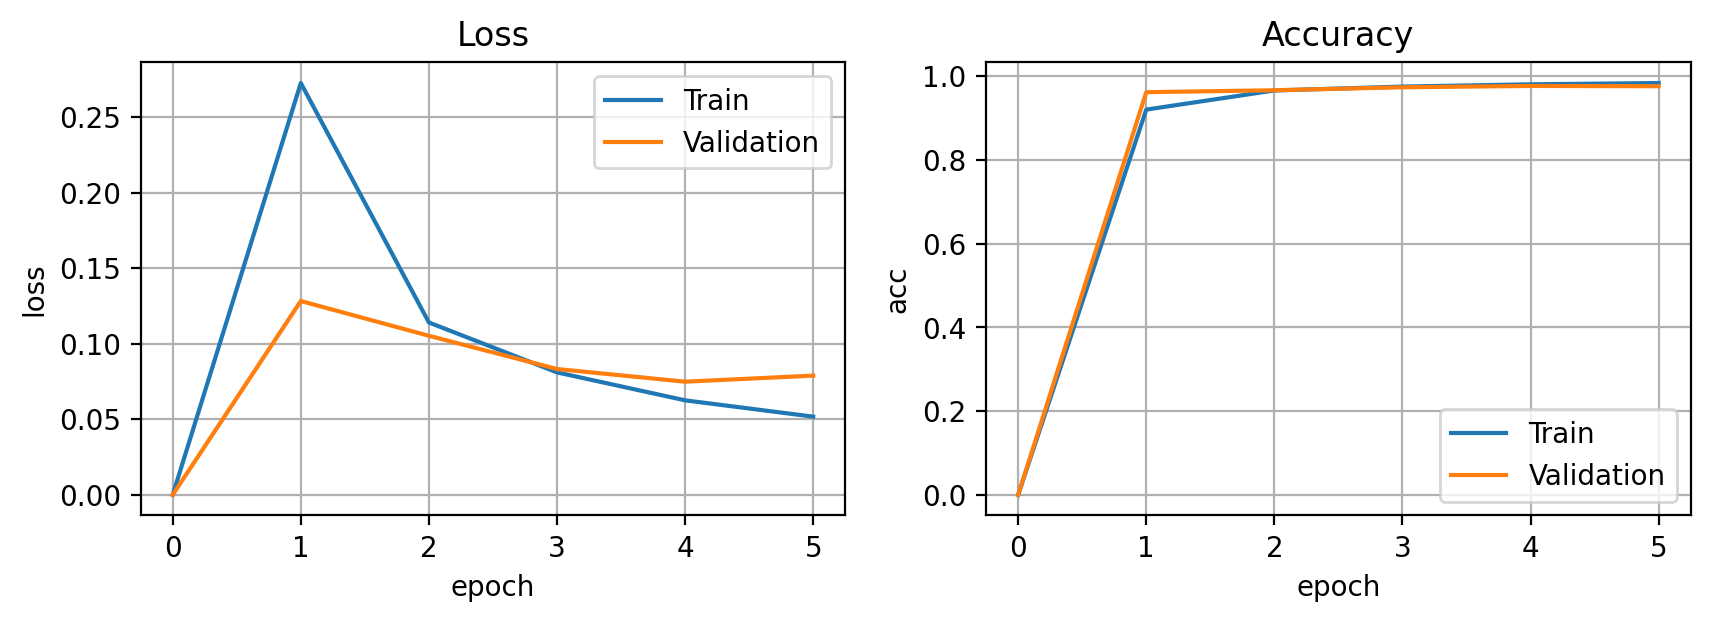

In [11]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(mlpTrainLoss, label="Train")
ax.plot(mlpValLoss, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(mlpTrainAcc, label="Train")
ax.plot(mlpValAcc, label="Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## CNN

In [12]:
dataloader = {
    'train': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./Convolucional', train=True, download=True,
                       transform = torchvision.transforms.Compose([
                            torchvision.transforms.ToTensor(),
                            torchvision.transforms.Normalize((0.1307,), (0.3081,))
                            ])
                      ), batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(torchvision.datasets.MNIST('./Convolucional', train=False, download=True,
                     transform = torchvision.transforms.Compose([
                        torchvision.transforms.ToTensor(),
                        torchvision.transforms.Normalize((0.1307,), (0.3081,))
                        ])
                     ), batch_size=64, shuffle=False, pin_memory=True)
}

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/train-images-idx3-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/train-labels-idx1-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Convolucional/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./Convolucional/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Convolucional/MNIST/raw



In [13]:
def block(c_in, c_out, k=3, p=1, s=1, pk=2, ps=2):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(pk, stride=ps)
    )

class CNN(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = block(n_channels, 64)
    self.conv2 = block(64, 128)
    self.fc = torch.nn.Linear(128*7*7, n_outputs)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = x.view(x.shape[0], -1)
    x = self.fc(x)
    return x

In [14]:
def fit(model, dataloader, epochs=5):
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = torch.nn.CrossEntropyLoss()
  convTrainLossMean, convValLossMean, convTrainAccMean, convValAccMean = [0.0], [0.0], [0.0], [0.0]
  for epoch in range(1, epochs+1):
    model.train()
    convTrainLoss, convTrainAcc = [], []
    batches = dataloader['train']
    for batch in batches:
      X, y = batch
      X, y = X.to(device), y.to(device)
      optimizer.zero_grad()
      y_hat = model(X)
      loss = criterion(y_hat, y)
      loss.backward()
      optimizer.step()
      convTrainLoss.append(loss.item())
      acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
      convTrainAcc.append(acc)
    batches = dataloader['test']
    convValLoss, convValAcc = [], []
    model.eval()
    with torch.no_grad():
      for batch in batches:
        X, y = batch
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = criterion(y_hat, y)
        convValLoss.append(loss.item())
        acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
        convValAcc.append(acc)
    convTrainLossMean.append(np.mean(convTrainLoss))
    convValLossMean.append(np.mean(convValLoss))
    convTrainAccMean.append(np.mean(convTrainAcc))
    convValAccMean.append(np.mean(convValAcc))
    print(f"Epoch {epoch}/{epochs} loss {np.mean(convTrainLoss):.5f} val_loss {np.mean(convValLoss):.5f} acc {np.mean(convTrainAcc):.5f} val_acc {np.mean(convValAcc):.5f}")
  return convTrainLossMean, convValLossMean, convTrainAccMean, convValAccMean

In [15]:
CNNmodel = CNN()

epochs = 5

convTrainLoss, convValLoss, convTrainAcc, convValAcc = fit(CNNmodel, dataloader, epochs=epochs)

Epoch 1/5 loss 0.11222 val_loss 0.04155 acc 0.96535 val_acc 0.98607
Epoch 2/5 loss 0.03972 val_loss 0.04997 acc 0.98744 val_acc 0.98358
Epoch 3/5 loss 0.02692 val_loss 0.03174 acc 0.99140 val_acc 0.98935
Epoch 4/5 loss 0.02029 val_loss 0.03516 acc 0.99347 val_acc 0.98905
Epoch 5/5 loss 0.01567 val_loss 0.02860 acc 0.99500 val_acc 0.98975


In [16]:
torch.save(CNNmodel.state_dict(), "/content/drive/MyDrive/Tesis/CNNmodel.pt")

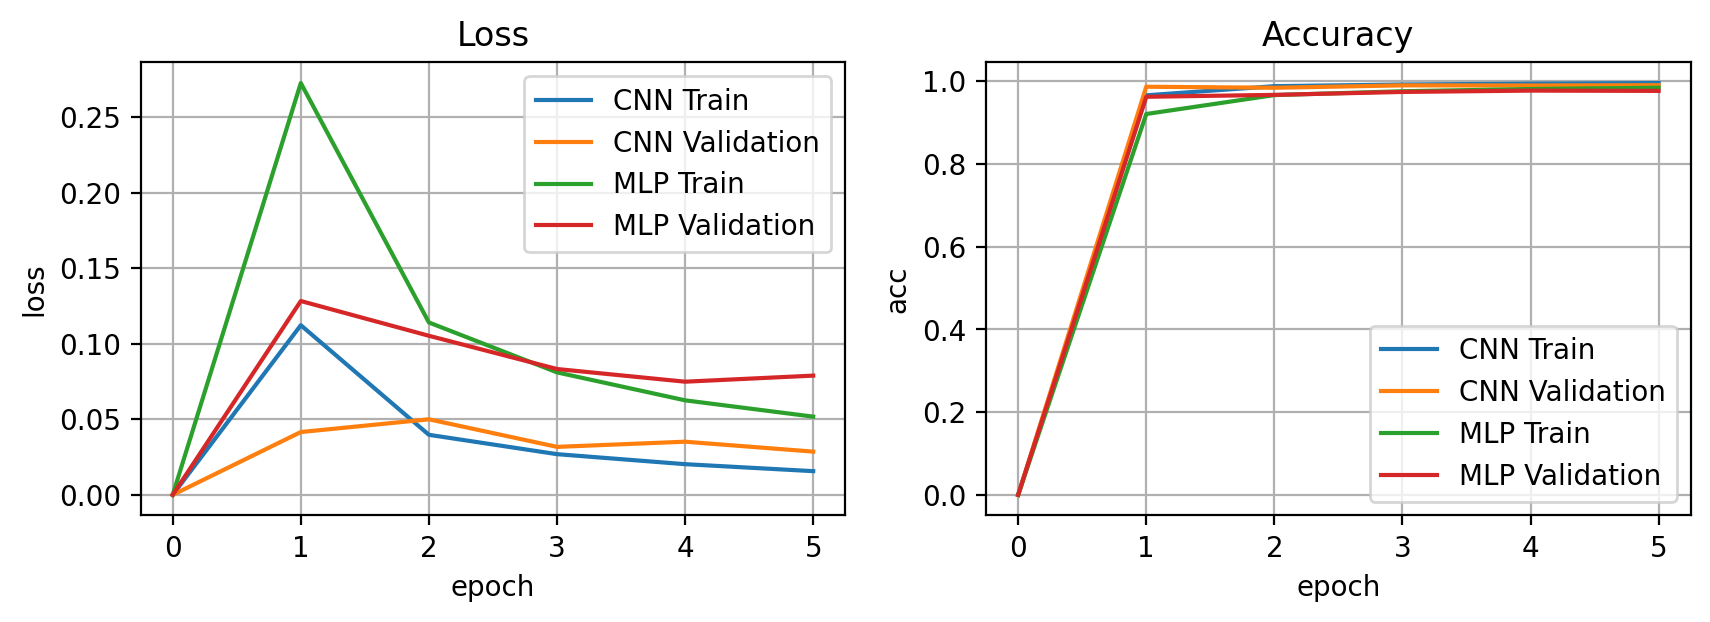

In [17]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(convTrainLoss, label="CNN Train")
ax.plot(convValLoss, label="CNN Validation")
ax.plot(mlpTrainLoss, label="MLP Train")
ax.plot(mlpValLoss, label="MLP Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(convTrainAcc, label="CNN Train")
ax.plot(convValAcc, label="CNN Validation")
ax.plot(mlpTrainAcc, label="MLP Train")
ax.plot(mlpValAcc, label="MLP Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## GNN

In [18]:
train = torchvision.datasets.MNIST('./GNN', train=True, download=True)
test = torchvision.datasets.MNIST('./GNN', train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/train-images-idx3-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/train-labels-idx1-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/t10k-images-idx3-ubyte.gz to ./GNN/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./GNN/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./GNN/MNIST/raw



In [19]:
def createNodesandEdges(data, labels):
  listData = []
  for n, imgit in enumerate(data):
    imgit = imgit.numpy()
    imgit = np.where(imgit == 0, -1, imgit)
    imgit = np.pad(imgit, [(2, 2), (2, 2)], "constant", constant_values = (0))

    cnt = 0

    for i in range(2, 30):
      for j in range(2, 30):
        if (imgit[i][j] > -1):
          imgit[i][j] = cnt
          cnt = cnt + 1
    
    edges = []
    nodes = np.zeros((cnt, 2))

    for i in range(2, 30):
      for j in range(2, 30):
        if (imgit[i][j] == -1):
          continue

        filter = imgit[i - 2:i + 3, j - 2:j + 3].flatten()
        filterVal = filter[[6, 7, 8, 11, 13, 16, 17, 18]]

        nodes[filter[12]][0] = i - 2
        nodes[filter[12]][1] = j - 2

        for val in filterVal:
          if (not val == -1):
            edges.append([filter[12], val])

    edge = torch.tensor(np.array(edges).T, dtype=torch.long)
    node = torch.tensor(nodes/28, dtype=torch.float)

    d = Data(x=node, edge_index=edge.contiguous(), t=labels[n])
    listData.append(d)

    if(n % 1000 == 999):
      print("\rLoaded: " + str(n + 1), end=" ")
    
  print("Finished")
  return listData

In [20]:
trainData = createNodesandEdges(train.data, train.targets)

Loaded: 60000 Finished


In [21]:
testData = createNodesandEdges(test.data, test.targets)

Loaded: 10000 Finished


In [22]:
dataloader = {
    'train': trainData,
    'test': testData
}

In [27]:
class GCN(torch.nn.Module):
  def __init__(self):
    super(GCN, self).__init__()
    self.conv1 = GCNConv(2, 16)
    self.conv2 = GCNConv(16, 32)
    self.conv3 = GCNConv(32, 64)
    self.conv4 = GCNConv(64, 96)
    self.conv5 = GCNConv(96, 128)
    self.linear1 = torch.nn.Linear(128,64)
    self.linear2 = torch.nn.Linear(64,10)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index

    x = self.conv1(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv2(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv3(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv4(x, edge_index)
    x = torch.nn.functional.relu(x)

    x = self.conv5(x, edge_index)
    x = torch.nn.functional.relu(x)
        
    x, _ = scatter_max(x, data.batch, dim=0)
    x = self.linear1(x)
    x = torch.nn.functional.relu(x)

    x = self.linear2(x)
    return x

In [28]:
def fit(model, dataloader, batch_size, epochs=5):
  model = model.to(device)
  optimizer = torch.optim.Adam(model.parameters())
  criterion = torch.nn.CrossEntropyLoss()
  
  trainset = dataloader['train']
  trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
  
  testset = dataloader['test']
  testloader = DataLoader(testset, batch_size=batch_size)

  gcnTrainLossMean, gcnValLossMean, gcnTrainAccMean, gcnValAccMean = [0.0], [0.0], [0.0], [0.0]

  for epoch in range(1, epochs+1):
    model.train()
    gcnTrainLoss, gcnTrainAcc = [], []
    for batch in trainloader:
      batch = batch.to(device)
      optimizer.zero_grad()
      y_hat = model(batch)
      loss = criterion(y_hat, batch.t)
      loss.backward()
      optimizer.step()
      gcnTrainLoss.append(loss.item())
      acc = (batch.t == torch.argmax(y_hat, axis=1)).sum().item() / len(batch.t)
      gcnTrainAcc.append(acc)
    gcnValLoss, gcnValAcc = [], []
    model.eval()
    with torch.no_grad():
      for batch in testloader:
        batch = batch.to(device)
        y_hat = model(batch)
        loss = criterion(y_hat, batch.t)
        gcnValLoss.append(loss.item())
        acc = (batch.t == torch.argmax(y_hat, axis=1)).sum().item() / len(batch.t)
        gcnValAcc.append(acc)
    gcnTrainLossMean.append(np.mean(gcnTrainLoss))
    gcnValLossMean.append(np.mean(gcnValLoss))
    gcnTrainAccMean.append(np.mean(gcnTrainAcc))
    gcnValAccMean.append(np.mean(gcnValAcc))
    print(f"Epoch {epoch}/{epochs} loss {np.mean(gcnTrainLoss):.5f} val_loss {np.mean(gcnValLoss):.5f} acc {np.mean(gcnTrainAcc):.5f} val_acc {np.mean(gcnValAcc):.5f}")
  return gcnTrainLossMean, gcnValLossMean, gcnTrainAccMean, gcnValAccMean
    

In [29]:
GCNmodel = GCN()

batch_size = 100
epochs = 5

gcnTrainLoss, gcnValLoss, gcnTrainAcc, gcnValAcc = fit(GCNmodel, dataloader, batch_size=batch_size, epochs=epochs)

Epoch 1/5 loss 1.51425 val_loss 0.98081 acc 0.45510 val_acc 0.67870
Epoch 2/5 loss 0.92824 val_loss 0.79077 acc 0.69225 val_acc 0.75500
Epoch 3/5 loss 0.76983 val_loss 0.67431 acc 0.75417 val_acc 0.78730
Epoch 4/5 loss 0.65923 val_loss 0.61624 acc 0.79262 val_acc 0.80080
Epoch 5/5 loss 0.60087 val_loss 0.55624 acc 0.81112 val_acc 0.82820


In [30]:
torch.save(GCNmodel.state_dict(), "/content/drive/MyDrive/Tesis/GCNmodel.pt")

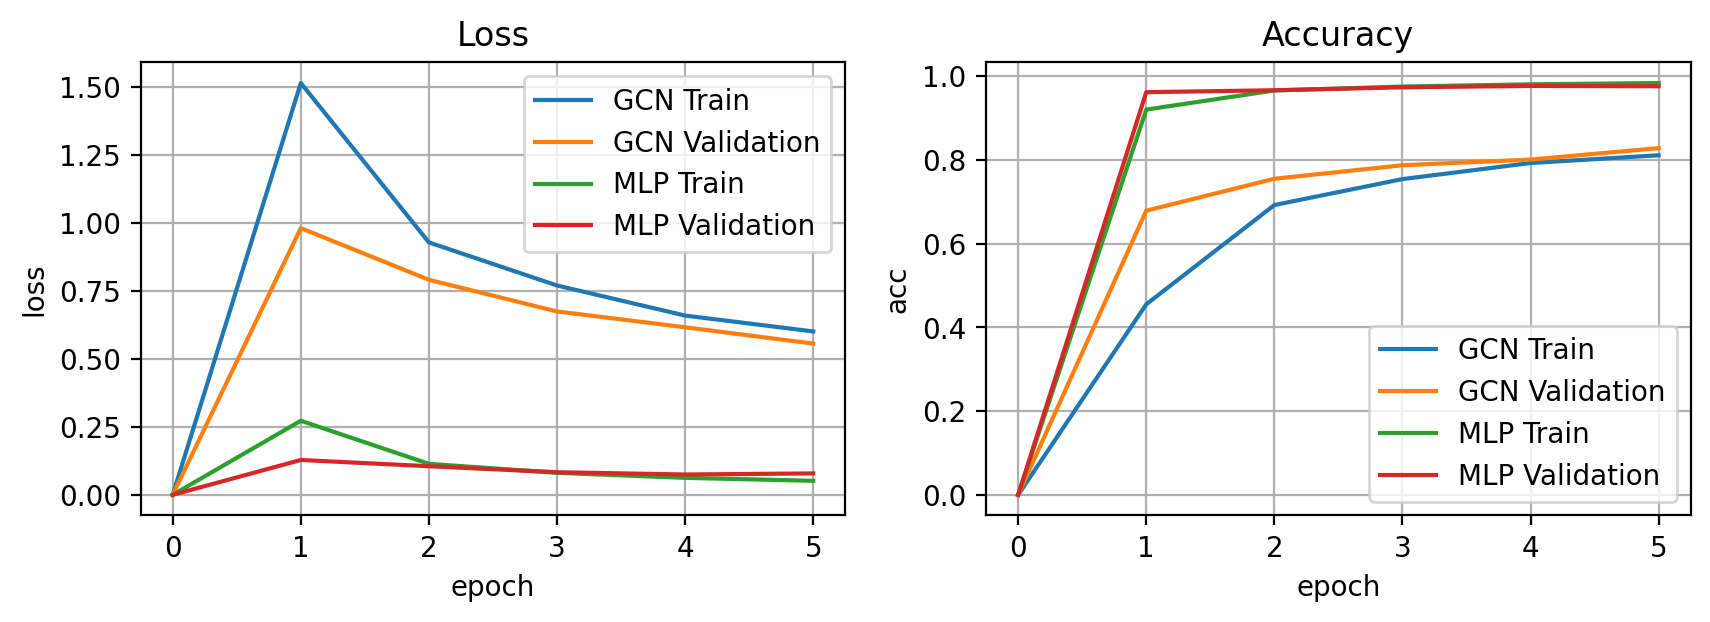

In [31]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(gcnTrainLoss, label="GCN Train")
ax.plot(gcnValLoss, label="GCN Validation")
ax.plot(mlpTrainLoss, label="MLP Train")
ax.plot(mlpValLoss, label="MLP Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(gcnTrainAcc, label="GCN Train")
ax.plot(gcnValAcc, label="GCN Validation")
ax.plot(mlpTrainAcc, label="MLP Train")
ax.plot(mlpValAcc, label="MLP Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

## Comparación

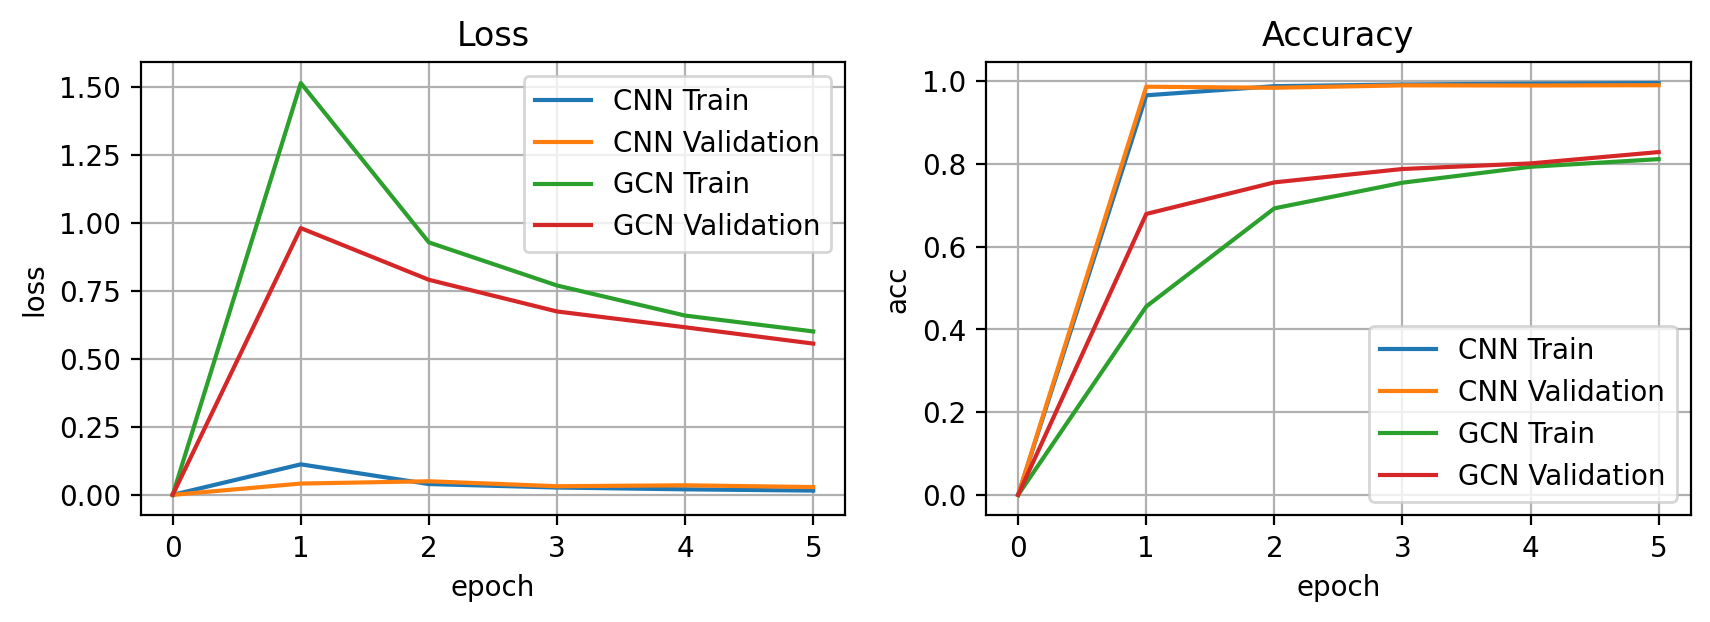

In [32]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(convTrainLoss, label="CNN Train")
ax.plot(convValLoss, label="CNN Validation")
ax.plot(gcnTrainLoss, label="GCN Train")
ax.plot(gcnValLoss, label="GCN Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(convTrainAcc, label="CNN Train")
ax.plot(convValAcc, label="CNN Validation")
ax.plot(gcnTrainAcc, label="GCN Train")
ax.plot(gcnValAcc, label="GCN Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()

In [33]:
GCNmodel20 = GCN()

batch_size = 100
epochs = 20

gcnTrainLoss20, gcnValLoss20, gcnTrainAcc20, gcnValAcc20 = fit(GCNmodel20, dataloader, batch_size=batch_size, epochs=epochs)

Epoch 1/20 loss 1.50839 val_loss 1.11627 acc 0.45155 val_acc 0.63950
Epoch 2/20 loss 0.96415 val_loss 0.79341 acc 0.68373 val_acc 0.75160
Epoch 3/20 loss 0.75354 val_loss 0.69356 acc 0.76007 val_acc 0.78730
Epoch 4/20 loss 0.65463 val_loss 0.60072 acc 0.79410 val_acc 0.80900
Epoch 5/20 loss 0.57599 val_loss 0.52106 acc 0.81778 val_acc 0.83550
Epoch 6/20 loss 0.48710 val_loss 0.50014 acc 0.84352 val_acc 0.83670
Epoch 7/20 loss 0.42668 val_loss 0.38573 acc 0.86263 val_acc 0.87850
Epoch 8/20 loss 0.38383 val_loss 0.34739 acc 0.87813 val_acc 0.89140
Epoch 9/20 loss 0.35666 val_loss 0.34140 acc 0.88607 val_acc 0.89400
Epoch 10/20 loss 0.33133 val_loss 0.28962 acc 0.89495 val_acc 0.90940
Epoch 11/20 loss 0.31493 val_loss 0.29154 acc 0.90058 val_acc 0.90900
Epoch 12/20 loss 0.29965 val_loss 0.27188 acc 0.90488 val_acc 0.91570
Epoch 13/20 loss 0.28694 val_loss 0.26730 acc 0.90928 val_acc 0.91750
Epoch 14/20 loss 0.27341 val_loss 0.26228 acc 0.91297 val_acc 0.92050
Epoch 15/20 loss 0.26459 val_

In [34]:
torch.save(GCNmodel20.state_dict(), "/content/drive/MyDrive/Tesis/GCNmodel20.pt")

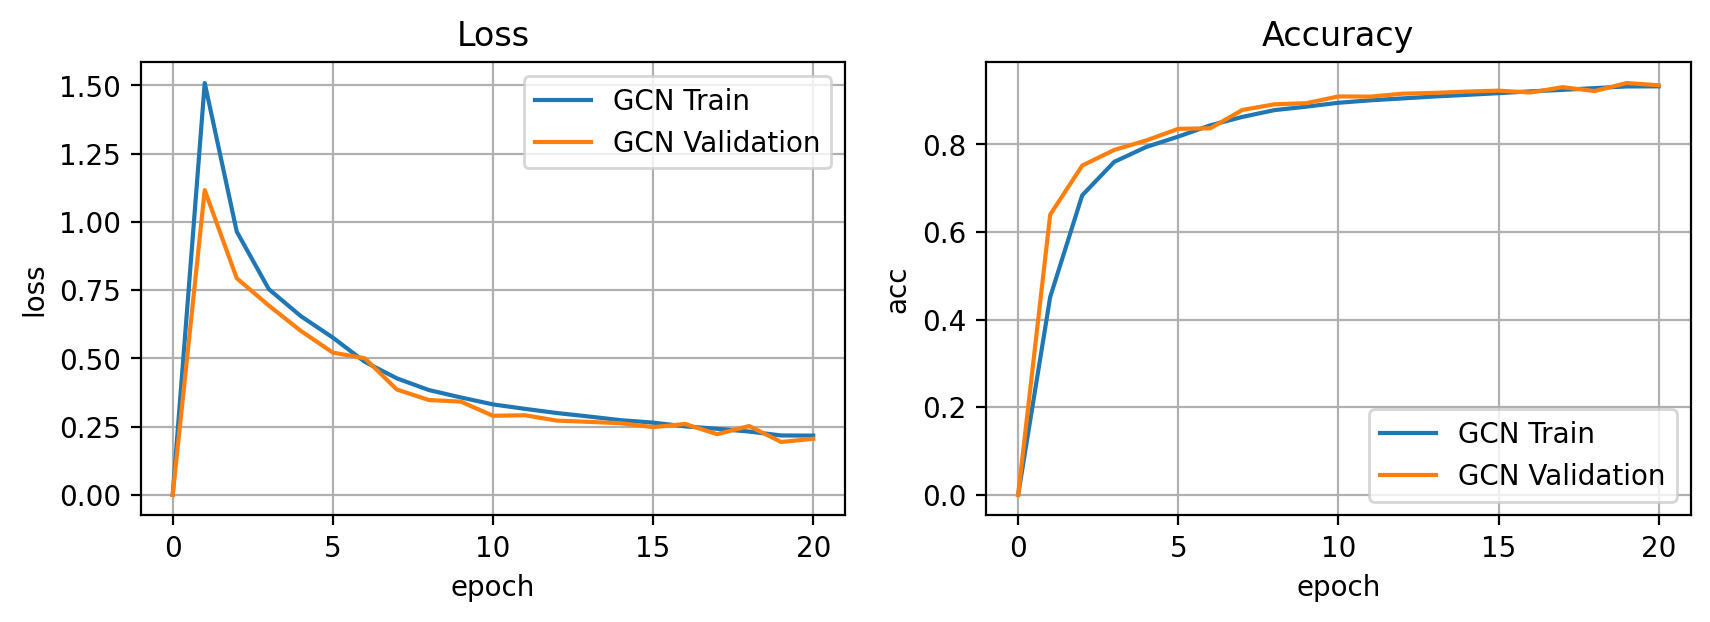

In [37]:
fig = plt.figure(dpi=200, figsize=(10,3))
ax = plt.subplot(121)
ax.plot(gcnTrainLoss20, label="GCN Train")
ax.plot(gcnValLoss20, label="GCN Validation")
ax.legend()
ax.grid(True)
ax.set_title('Loss')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax = plt.subplot(122)
ax.plot(gcnTrainAcc20, label="GCN Train")
ax.plot(gcnValAcc20, label="GCN Validation")
ax.legend()
ax.grid(True)
ax.set_title('Accuracy')
ax.set_ylabel('acc')
ax.set_xlabel('epoch')
plt.show()